## 0. Import libraries

In [23]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


## 1. Load Data

In [24]:
df = pd.read_csv('./total.csv')
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5334,2024-05-10,5222.680176,1365.400024,2367.300049,2727.629883,2727.209961
5335,2024-05-13,5221.419922,1370.109985,2336.100098,2727.209961,2730.340088
5336,2024-05-14,5246.680176,1363.790039,2353.399902,2730.340088,2753.000000
5337,2024-05-15,5308.149902,1362.550049,2388.699951,2730.340088,2753.000000
5338,2024-05-16,5308.149902,1362.550049,2387.100098,2753.000000,2753.000000


In [25]:
col_names = df.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [26]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
LR = 1e-4

## 2. Split data train and test

In [27]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi,kospi_shift
mean,2.058553e+03,1120.303866,1211.516482,1907.663422,1907.894126
var,1.037695e+06,11153.970584,197132.037659,285092.585746,285066.573366
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [28]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5334,1.103426,0.699147,1.188346,0.776618,0.776456
5335,1.103121,0.706026,1.169738,0.776456,0.777667
5336,1.109252,0.696796,1.180056,0.777667,0.786430
5337,1.124171,0.694985,1.201109,0.777667,0.786430
5338,1.124171,0.694985,1.200155,0.786430,0.786430


In [29]:
class StockDataset(Dataset):
    def __init__(self, y, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        print(y.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[:,i] = y[end_x: end_x + output_window]
        # print(X.shape, Y.shape)
        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

### 3. create dataloader

In [30]:
train_dataset = StockDataset(train_data['kospi'], 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data['kospi'], 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
# print(next(iter(test_dataset)))

(5072,) 4944 4944 0 5072
(4944, 128, 1) (4944, 1, 1)
(267,) 139 139 0 267
(139, 128, 1) (139, 1, 1)
78 4944 (128, 1) (1, 1)


## 3. Build a model

In [31]:
class LinearEmbedding(nn.Module):
    def __init__(self, dropout, d_model):
        '''
        data: [batch_size, seq_len, 1]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(1, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, 1]
        output: [batch_size, seq_len, d_model]
        '''
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x

In [32]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.droptout = dropout

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.emb = LinearEmbedding(dropout, input_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size//2)
        self.linear2 = nn.Linear(hidden_size//2, 1)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.emb(x)
        # print(x.size())
        lstm_out, self.hidden = self.lstm(x)
        # print(lstm_out[:, -1, :].size())
        x = self.linear1(lstm_out[:, -1, :])
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        # print(x.size())
        return x


## 4. Model, loss_fn, optimizer

In [33]:
batch_size, seq_len, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_d = 64
dropout = 0.2
n_hidden = 64
n_layers = 1
# lr_sched = False
lr_sched = True

64 128 1


In [34]:
model = lstm_encoder(model_d, n_hidden, dropout, n_layers).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 2e-4)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.7)

c:\Users\alan.kwak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## 5. Train and Test

In [35]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 1])
torch.Size([64, 1, 1])
torch.Size([64])


In [36]:
epochs = 1000
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.squeeze(1).to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output.float(), labels.float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 8))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

epochs: 0, loss: 5.214677, lr:  0.0002
epochs: 1, loss: 1.485392, lr:  0.0002
epochs: 2, loss: 0.503251, lr:  0.0002
epochs: 3, loss: 0.472929, lr:  0.0002
epochs: 4, loss: 0.379181, lr:  0.0002
epochs: 5, loss: 0.344359, lr:  0.0002
epochs: 6, loss: 0.330539, lr:  0.0002
epochs: 7, loss: 0.309636, lr:  0.0002
epochs: 8, loss: 0.295908, lr:  0.0002
epochs: 9, loss: 0.288116, lr:  0.0002
epochs: 10, loss: 0.292101, lr:  0.0002
epochs: 11, loss: 0.268849, lr:  0.0002
epochs: 12, loss: 0.267502, lr:  0.0002
epochs: 13, loss: 0.266424, lr:  0.0002
epochs: 14, loss: 0.282972, lr:  0.0002
epochs: 15, loss: 0.273722, lr:  0.0002
epochs: 16, loss: 0.265756, lr:  0.0002
epochs: 17, loss: 0.262437, lr:  0.0002
epochs: 18, loss: 0.251997, lr:  0.0002
epochs: 19, loss: 0.247552, lr:  0.0002
epochs: 20, loss: 0.256749, lr:  0.0002
epochs: 21, loss: 0.230030, lr:  0.0002
epochs: 22, loss: 0.233266, lr:  0.0002
epochs: 23, loss: 0.237180, lr:  0.0002
epochs: 24, loss: 0.228846, lr:  0.0002
epochs: 25

In [37]:
save_path = 'lstm_kospi_only_window_seqlen' + str(seq_len) + '_layaers' + str(n_layers)  + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
df_loss

,epoch,loss
0,0.0,5.214677
1,1.0,1.485392
2,2.0,0.503251
3,3.0,0.472929
4,4.0,0.379181
...,...,...
995,995.0,0.077202
996,996.0,0.079593
997,997.0,0.080128
998,998.0,0.077810


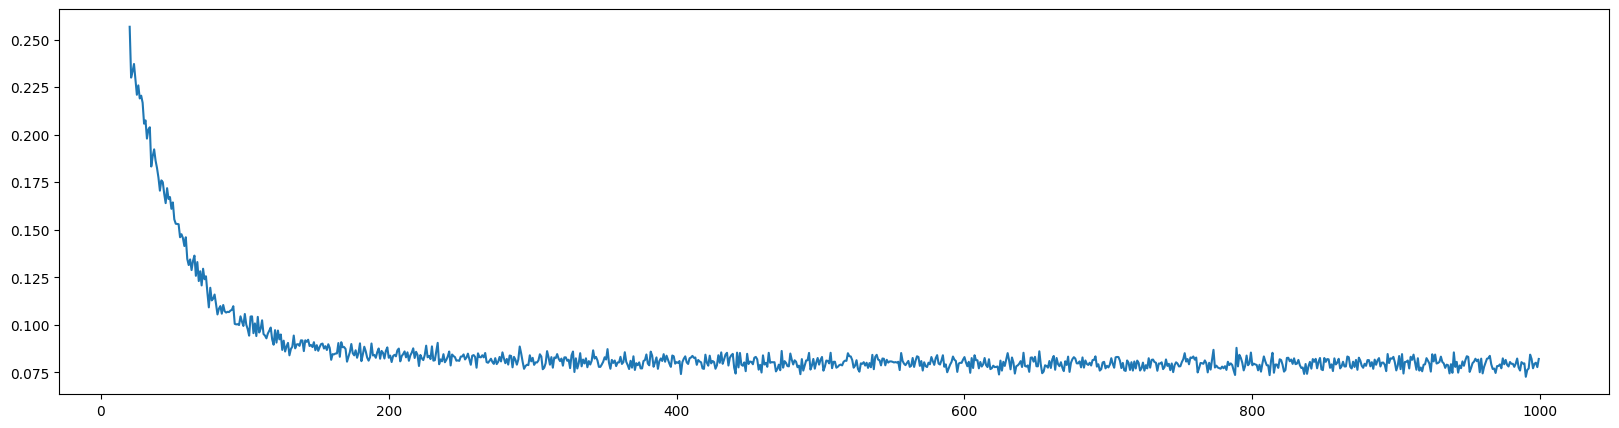

In [38]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[20: , 'epoch'], df_loss.loc[20: , 'loss'])
plt.show()

In [39]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0][0]]
            num += 1

In [40]:
test_result.tail(10)

,pred,pred_rescale,real
129,0.772341,2716.571425,2676.629883
130,0.824968,2852.643065,2676.629883
131,0.785713,2751.146345,2734.360107
132,0.745049,2646.002956,2745.050049
133,0.750141,2659.169613,2712.139893
134,0.730832,2609.243148,2727.629883
135,0.732009,2612.286302,2727.209961
136,0.762699,2691.639477,2730.340088
137,0.743706,2642.530746,2730.340088
138,0.770384,2711.510752,2753.000000


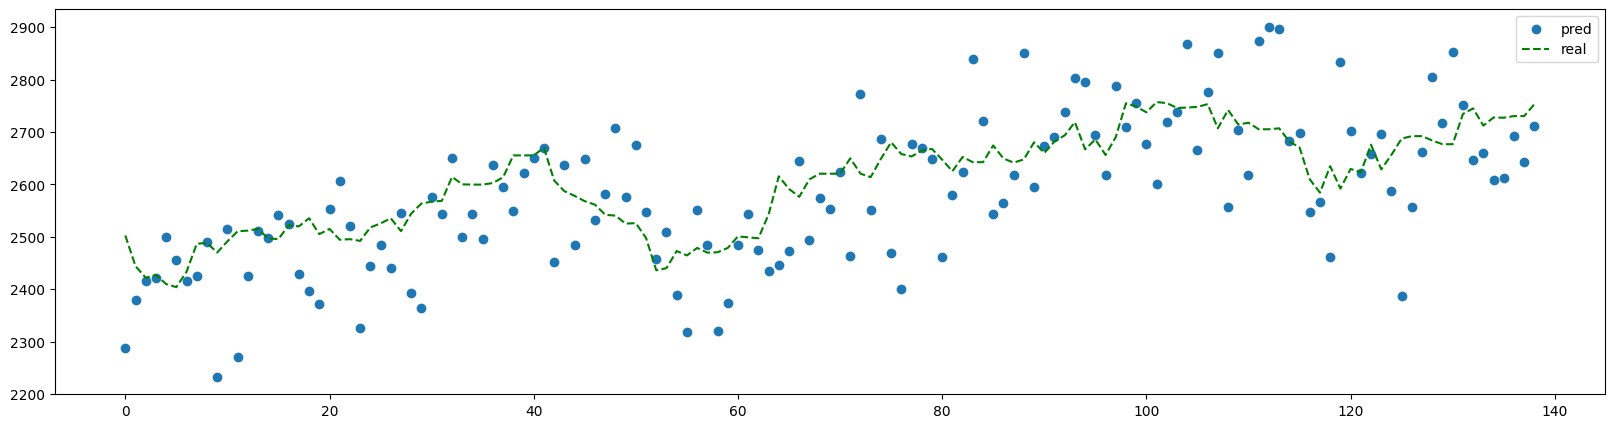

In [41]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

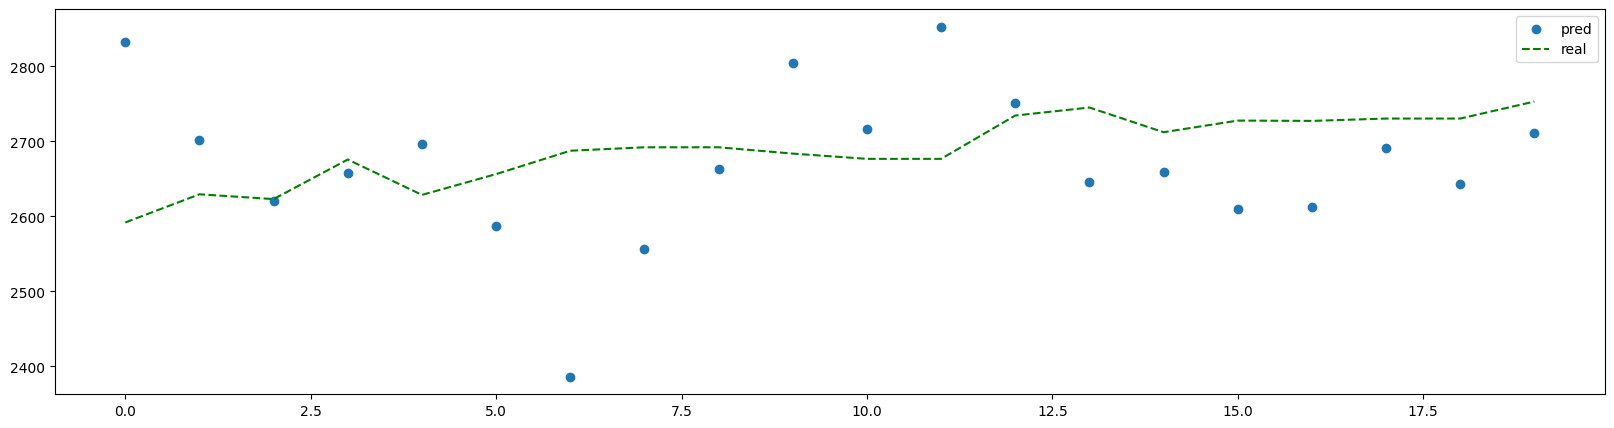

In [42]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

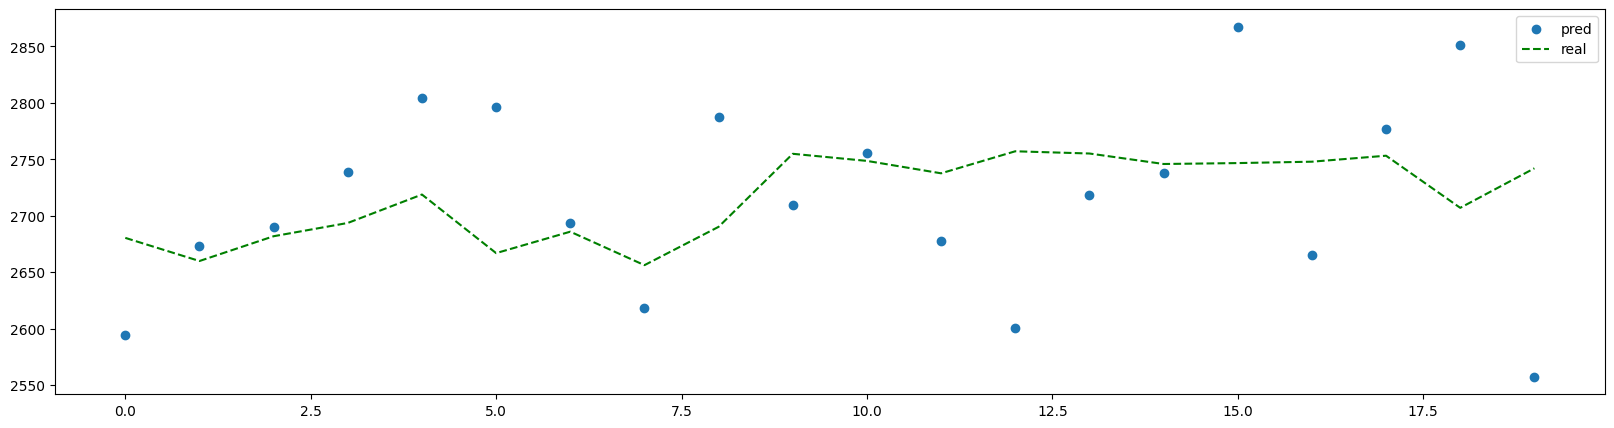

In [43]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

## 6. evaluation metrics
MAPE, MSE

In [44]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 11192.3613, MAPE: 0.0314
